In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib
import matplotlib.pyplot as plt

In [2]:
races_df = pd.read_csv(r"../data/races.csv", delimiter=",", header=0, index_col='race_id')
races_df = races_df[['venue', 'config', 'surface', 'distance', 'going', 'race_class']]

# check to see if we have NaN, then drop NaN
print(races_df[races_df.isnull().any(axis=1)])
races_df = races_df.dropna()

# encode ordinal columns: config, going
config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1))
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

# encode nominal column: venue
venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

Empty DataFrame
Columns: [venue, config, surface, distance, going, race_class]
Index: []


In [3]:
races_df.head()

,venue,config,surface,distance,going,race_class
race_id,,,,,,
0,1,0.0,0,1400,2.0,5
1,1,0.0,0,1200,2.0,5
2,1,0.0,0,1400,2.0,4
3,1,0.0,0,1200,2.0,1
4,1,0.0,0,1600,2.0,4


In [4]:
runs_df = pd.read_csv(r"../data/runs.csv", delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 
                   'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds', 
                   'result']] 

# check to see if we have NaN, then drop NaN
print(runs_df[runs_df.isnull().any(axis=1)])
runs_df = runs_df.dropna()

# got some strange draw in the dataset. Maximum shall be 14
strange_draw_index = runs_df[runs_df['draw'] > 14].index

# delete these row indexes from dataFrame
runs_df = runs_df.drop(strange_draw_index)

# encode nominal columns: horse_country, horse_type
horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = horse_country_encoder.fit_transform(runs_df['horse_country'])
horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = horse_type_encoder.fit_transform(runs_df['horse_type'])

     race_id  draw  horse_age horse_country horse_type  horse_rating  \
182       13    12          3           NaN        NaN            60   
846       69     1          3           NaN        NaN            60   

     declared_weight  actual_weight  win_odds  result  
182           1107.0            120      28.0       5  
846           1105.0            119      14.0      11  


In [5]:
runs_df.head()

,race_id,draw,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,win_odds,result
0,0,7,3,1,3,60,1020.0,133,9.7,10
1,0,12,3,11,3,60,980.0,133,16.0,8
2,0,8,3,11,3,60,1082.0,132,3.5,7
3,0,13,3,12,3,60,1118.0,127,39.0,9
4,0,14,3,5,3,60,972.0,131,50.0,6


In [6]:
def group_horse_and_result(element):
    if element[0] == 'result':
        return 100 + element[1]
    else:
        return element[1]   

runs_df = runs_df.pivot(index='race_id', columns='draw', values=runs_df.columns[2:])
rearranged_columns = sorted(list(runs_df.columns.values), key=group_horse_and_result)
runs_df = runs_df[rearranged_columns]
print(runs_df.head())

# quite some NaNs appreared in the dataframe, reason is some races didnt have full 14 horses participating
# fill with 0
runs_df = runs_df.fillna(0)

        horse_age horse_country horse_type horse_rating declared_weight  \
draw           1             1          1            1               1    
race_id                                                                   
0             3.0          14.0        3.0         60.0          1089.0   
1             3.0           1.0        3.0         60.0          1059.0   
2             3.0           1.0        3.0         60.0          1028.0   
3             3.0          14.0        5.0         60.0          1074.0   
4             3.0          11.0        3.0         60.0           988.0   

        actual_weight win_odds horse_age horse_country horse_type  ... result  \
draw               1        1         2             2          2   ...     5    
race_id                                                            ...          
0               120.0      5.4       3.0           1.0        3.0  ...    3.0   
1               121.0     10.0       3.0          11.0        3.0  ...    8

In [7]:
runs_df.head()

horse_age horse_country horse_type horse_rating declared_weight  \
draw           1             1          1            1               1    
race_id                                                                   
0             3.0          14.0        3.0         60.0          1089.0   
1             3.0           1.0        3.0         60.0          1059.0   
2             3.0           1.0        3.0         60.0          1028.0   
3             3.0          14.0        5.0         60.0          1074.0   
4             3.0          11.0        3.0         60.0           988.0   

        actual_weight win_odds horse_age horse_country horse_type  ... result  \
draw               1        1         2             2          2   ...     5    
race_id                                                            ...          
0               120.0      5.4       3.0           1.0        3.0  ...    3.0   
1               121.0     10.0       3.0          11.0        3.0  ...    8.0   
2               116.0     45.0       3.0          11.0        3.0  ...   14.0   
3               115.0      2.9       3.0          11.0        3.0  ...    3.0   
4               106.0     31.0       3.0          11.0        3.0  ...   14.0   

                                                               
draw       6     7     8     9     10    11    12    13    14  
race_id                                                        
0        13.0  10.0   7.0  14.0   4.0  12.0   8.0   9.0   6.0  
1         2.0   5.0  10.0  12.0   1.0   3.0   9.0  14.0  13.0  
2         6.0   4.0   7.0   9.0  10.0   5.0  11.0   3.0  12.0  
3        11.0   8.0   9.0   6.0  12.0   2.0  10.0   0.0   0.0  
4         6.0   2.0   8.0  10.0  13.0   7.0   4.0  11.0  12.0  

[5 rows x 112 columns]

In [8]:
data = races_df.join(runs_df, on='race_id', how='right')
X = data[data.columns[:-14]]
ss = preprocessing.StandardScaler()
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

# set NO.1 horse as 1 and losing horses as 0
y = data[data.columns[-14:]].applymap(lambda x: 1.0 if 0.5 < x < 1.5 else 0.0)

print(X.shape)
print(y.shape)

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

(6348, 104)
(6348, 14)


/Users/fuziru/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


# Build models

In [9]:
# 1. Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='sigmoid', input_shape=(104,)),
    tf.keras.layers.Dense(96, activation='sigmoid'),
    tf.keras.layers.Dense(14, activation='softmax')
])

# 2. Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(5e-04),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                10080     
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1358      
Total params: 20,750
Trainable params: 20,750
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# 3. Train the model
history = model.fit(X_train, y_train, batch_size = 10, epochs = 30,  validation_data=(X_test, y_test))

Epoch 1/30
508/508 [==============================] - 1s 2ms/step - loss: 2.6511 - accuracy: 0.0955 - val_loss: 2.5696 - val_accuracy: 0.1236
Epoch 2/30
508/508 [==============================] - 0s 733us/step - loss: 2.5386 - accuracy: 0.1253 - val_loss: 2.5405 - val_accuracy: 0.1165
Epoch 3/30
508/508 [==============================] - 0s 746us/step - loss: 2.4943 - accuracy: 0.1369 - val_loss: 2.5033 - val_accuracy: 0.1142
Epoch 4/30
508/508 [==============================] - 0s 749us/step - loss: 2.4438 - accuracy: 0.1608 - val_loss: 2.4640 - val_accuracy: 0.1417
Epoch 5/30
508/508 [==============================] - 0s 754us/step - loss: 2.3963 - accuracy: 0.1814 - val_loss: 2.4422 - val_accuracy: 0.1520
Epoch 6/30
508/508 [==============================] - 0s 750us/step - loss: 2.3634 - accuracy: 0.1904 - val_loss: 2.4182 - val_accuracy: 0.1535
Epoch 7/30
508/508 [==============================] - 0s 757us/step - loss: 2.3093 - accuracy: 0.2118 - val_loss: 2.4036 - val_accuracy: 0

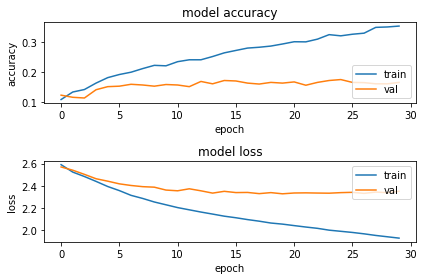

In [11]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

In [13]:
# 4. Evaluate the model.
model.evaluate(
  X_test,
  y_test
)

40/40 [==============================] - 0s 746us/step - loss: 2.3519 - accuracy: 0.1661


[2.3518917560577393, 0.16614173352718353]